In [11]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import matplotlib.cm
from pymfr.reconstruct import reconstruct_cross_section

max y0 9.999999999999998


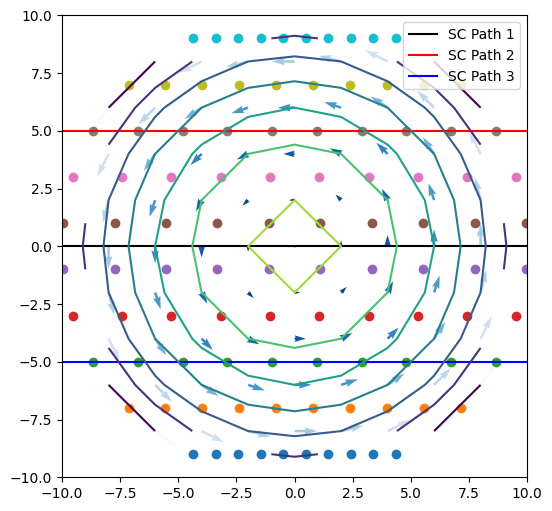

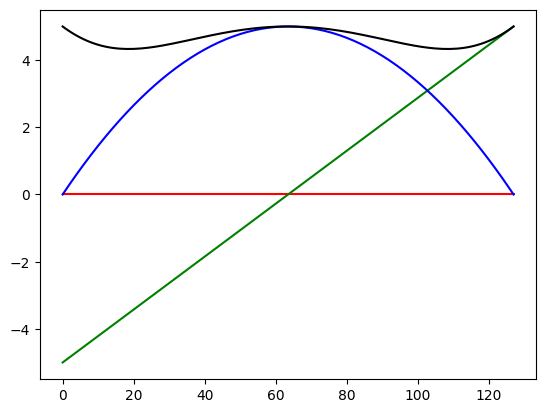

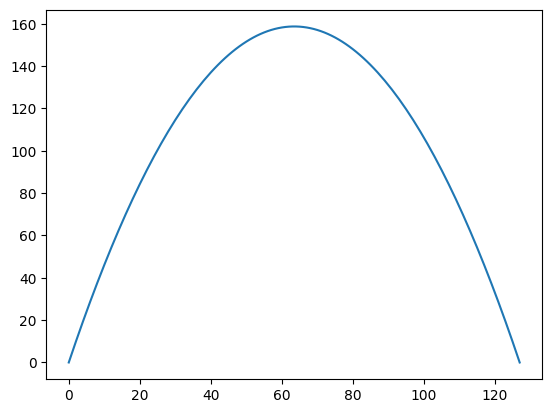

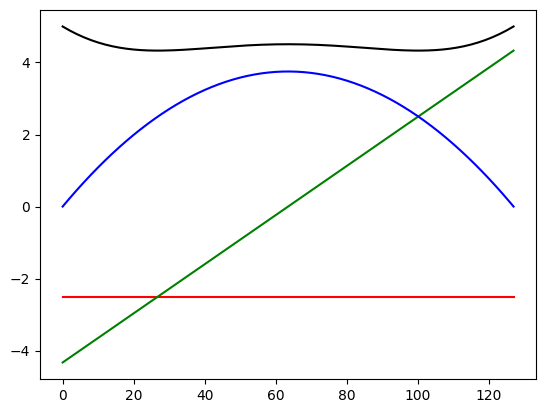

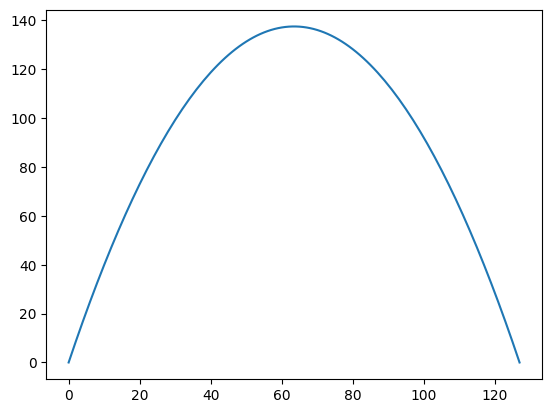

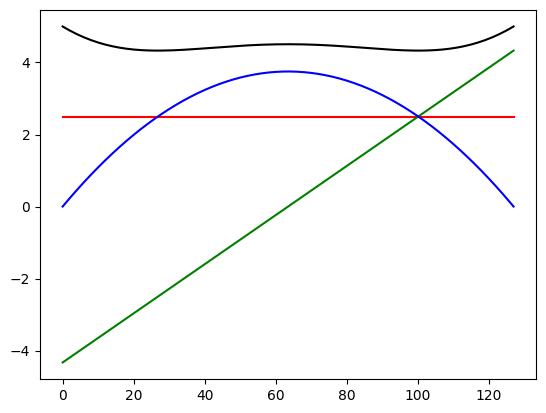

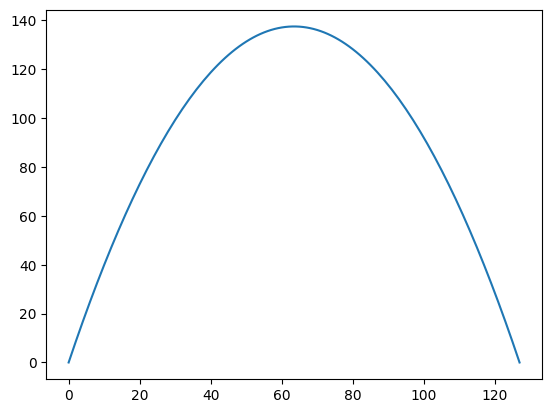

In [12]:
def elliptical_cylindrical(x, y, B0, R, C10, roll, delta, tau):
    assert x.shape == y.shape
    assert len(x.shape) == 1

    # in the paper, y is the axial component and x and z span the cross section such that the distortion is along the z axis.
    # here we want x to be spacecraft path in cross section, y to be vertical component of cross section, and z to be axial component
    # the paper provides a rotation matrix given the axis orientation and roll
    # set phi = 0 and theta = 90 degrees, we get cos(phi) = sin(theta) = 1 and cos(theta) = sin(phi) = 0, hence:
    # [cos(roll)    0    sin(roll);  sin(roll)    0    -cos(roll);  0    1    0]
    # i.e. the old y axis becomes the new z axis, whereas the other two axes appear to be a clockwise rotation by roll around the new z axis
    # so if roll = 0 or pi then the spacecraft travels along the model x axis, and if roll = +-pi/2 then along the model z axis
    model_to_xyz = np.array([[np.cos(roll), 0, np.sin(roll)], [np.sin(roll), 0, -np.cos(roll)], [0, 1, 0]])
    xyz_to_model = model_to_xyz.T

    # apply matrix multiplication by multiplying first and second columns by x and y and then adding. shape should be (N, 3)
    model_position_cartesian = xyz_to_model[:, 0][None, :] * x[:, None] + xyz_to_model[:, 1][None, :] * y[:, None]

    # x_model = delta r cos(phi) and z_model = r sin(phi), so tan(phi) = z_model/(x_model/delta), hence phi = arctan2(z_model, x_model/delta)
    phi = np.arctan2(model_position_cartesian[:, 2], model_position_cartesian[:, 0] / delta)

    # r^2 = (z_model^2 + x_model^2 / delta^2)
    r = np.sqrt(model_position_cartesian[:, 2] ** 2 + model_position_cartesian[:, 0] ** 2 / delta ** 2)

    # normalized radius
    r_bar = r / R
    
    B10 = B0 / tau / delta

    B_axial = delta * B10 * (tau - r_bar ** 2)

    h = (np.sqrt(delta ** 2 * np.sin(phi) ** 2 + np.cos(phi) ** 2))
    B_poloidal = -((2 * delta * h) / (delta ** 2 + 1)) * (B10 / C10) * r_bar

    basis_poloidal = np.stack([-delta * np.sin(phi), np.zeros_like(phi), np.cos(phi)], axis=-1) / h[:, None]

    Bx, By = tuple((model_to_xyz @ (basis_poloidal * B_poloidal[:, None]).T)[:2])
    Bz = B_axial
    return Bx, By, Bz


plt.figure(figsize=(6, 6))
radius = 10
B0 = 5
C10 = 1
roll = np.deg2rad(80)
delta = 1
tau = 1

# when b^2 = 4ac
max_y0 = np.abs(radius * np.cos(roll) * np.sqrt(1 + delta ** 2 * np.tan(roll) ** 2))
print("max y0", max_y0)


def spacecraft_path(y0, n):    
    # y_0 = sin(roll) x_L - cos(roll) z_L
    # -> z_L = tan(roll) * x_L - y0/cos(roll) defines the same line as y = y_0 when x is centered on the point that x_L = 0

    # R^2 = x_L^2/delta^2 + z_L^2 = x_L^2 / delta^2 + (tan(roll) * x_L - y0/cos(roll))^2
    # = x_L^2 / delta^2 + tan^2(roll) * x_L^2 - 2tan(roll)/cos(roll) x_L y_0 + y0^2/cos^2(roll)
    # -> x_L^2(1/delta^2 + tan^2(roll)) + x_L(-2y_0 tan(roll)/cos(roll)) + (y0^2/cos^2(roll) - R^2) = 0 

    a = 1 / delta ** 2 + np.tan(roll) ** 2
    b = -2 * np.tan(roll) / np.cos(roll) * y0
    c = y0**2 / np.cos(roll) ** 2  - radius ** 2
    x_L1 = (-b - np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
    x_L2 = (-b + np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
    z_L1 = np.tan(roll) * x_L1 - y0 / np.cos(roll)
    z_L2 = np.tan(roll) * x_L2 - y0 / np.cos(roll)

    x0 = np.cos(roll) * x_L1 + np.sin(roll) * z_L1
    x1 = np.cos(roll) * x_L2 + np.sin(roll) * z_L2

    x = np.linspace(x0, x1, n)

    y = np.linspace(y0, y0, n)
    return x, y


xx, yy = np.meshgrid(np.linspace(-radius, radius, 11), np.linspace(-radius, radius, 11))
xx_flat = xx.flatten()
yy_flat = yy.flatten()

Bx_flat, By_flat, Bz_flat = elliptical_cylindrical(xx_flat, yy_flat, B0=B0, R=radius, C10=C10, roll=roll, delta=delta, tau=tau)
plt.quiver(xx_flat, yy_flat, Bx_flat, By_flat, color=matplotlib.cm.Blues(np.where(Bz_flat < 0, np.nan, Bz_flat / Bz_flat.max())))
plt.axhline(0 * radius, color="black", label="SC Path 1")
plt.axhline(max_y0 * .5, color="red", label="SC Path 2")
plt.axhline(-max_y0 * .5, color="blue", label="SC Path 3")

y0s = np.linspace(-.9 * radius, .9 * radius, 10)
for y0 in y0s:
    plt.scatter(spacecraft_path(y0, 10)[0], np.ones(10) * y0)


plt.xlim(-radius, radius)
plt.ylim(-radius, radius)
plt.legend()

Bx = Bx_flat.reshape(xx.shape)
By = By_flat.reshape(xx.shape)
Bz = Bz_flat.reshape(xx.shape)
plt.contour(xx, yy, np.where(Bz < 0, np.nan, Bz).reshape(xx.shape))
plt.show()

for impact_parameter in [0, max_y0 * .5 / radius, -max_y0 * .5 / radius]:
    x, y = spacecraft_path(impact_parameter * radius, 128)
    Bx, By, Bz = elliptical_cylindrical(x, y, B0=B0, R=radius, C10=C10, roll=roll, delta=delta, tau=tau)

    plt.plot(Bx, color="red")
    plt.plot(By, color="green")
    plt.plot(Bz, color="blue")
    plt.plot(np.sqrt(Bx**2+By**2+Bz**2), color="black")
    plt.show()
    plt.plot(scipy.integrate.cumulative_trapezoid(-By, initial=0))
    plt.show()